## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [1]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [2]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [3]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [4]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [5]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [6]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [7]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [8]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [9]:
target = 'survived'

In [10]:
vars_num = [var for var in data.columns if data[var].dtype != 'O' and var != target and var != 'pclass']

vars_cat = [var for var in data.columns if var not in vars_num and var != target]

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 4
Number of categorical variables: 5


### Find missing values in variables

In [11]:
def get_first_label(df):
    print(f'Most sparse feature is {df[df==df[0]].index[0]} consisting for {df[0]} of empty values')

In [12]:
# first in numerical variables
num_na = data[vars_num].isnull().mean().sort_values(ascending=False)

get_first_label(num_na)

Most sparse feature is age consisting for 0.20091673032849502 of empty values


In [13]:
# now in categorical variables
cat_na = data[vars_cat].isnull().mean().sort_values(ascending=False)

get_first_label(cat_na)

Most sparse feature is cabin consisting for 0.774637127578304 of empty values


### Determine cardinality of categorical variables

<AxesSubplot: >

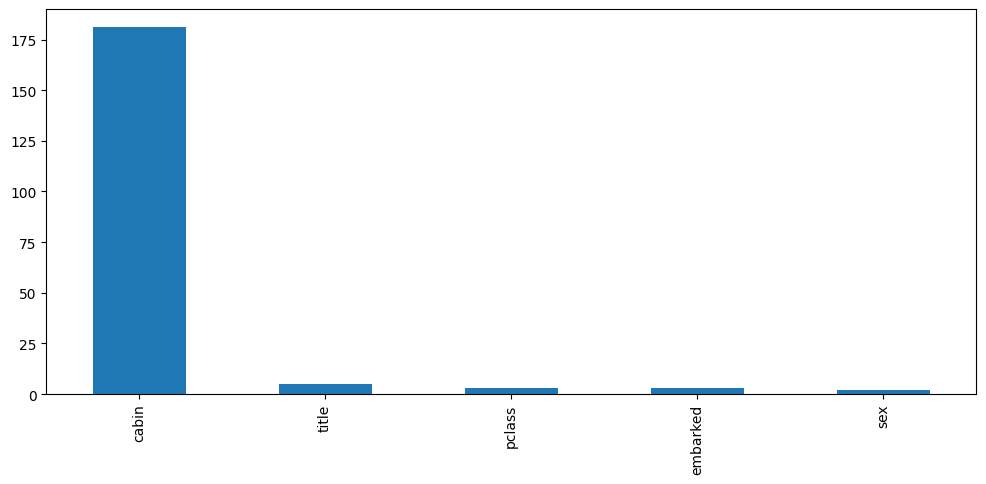

In [14]:
data[vars_cat].nunique().sort_values(ascending=False).plot.bar(figsize=(12,5))

### Determine the distribution of numerical variables

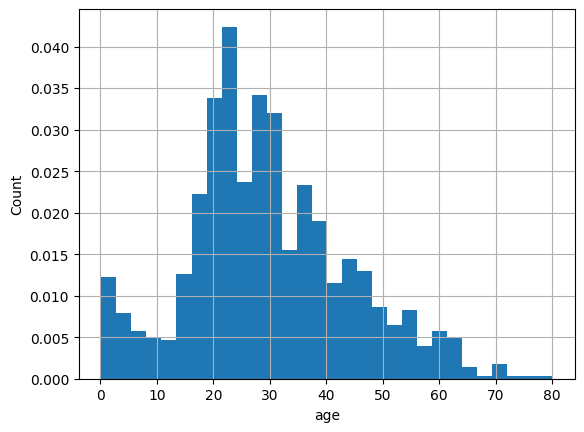

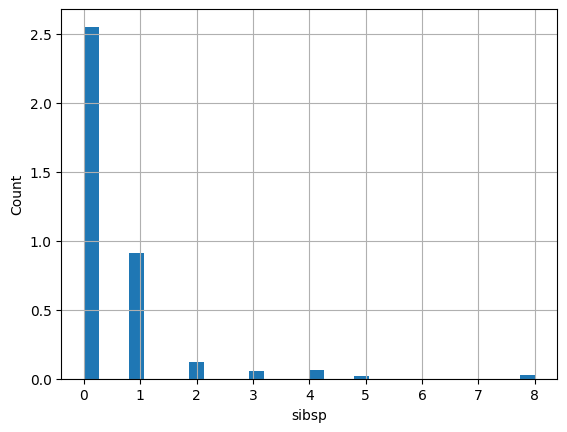

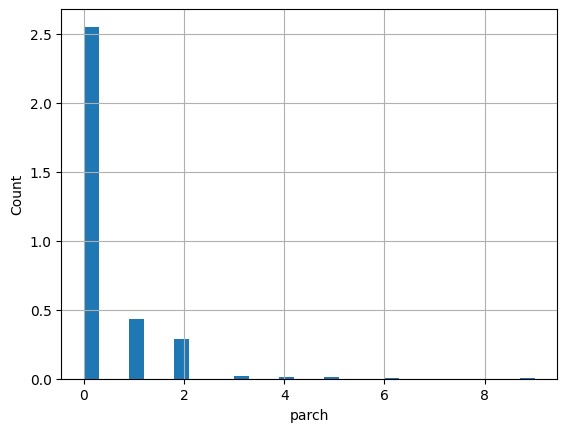

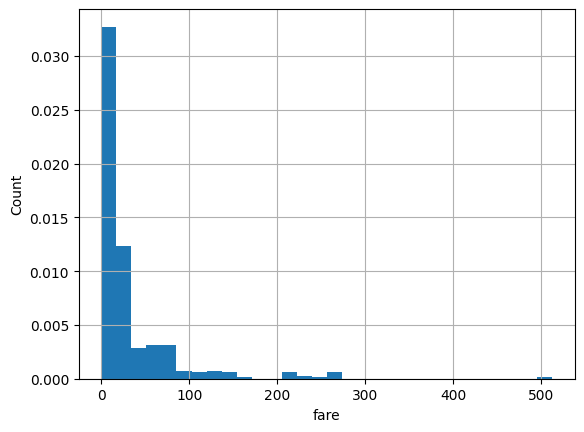

In [15]:
for var in vars_num:
    # histogran to evaluate target distribution
    data[var].hist(bins=30, density=True)
    plt.ylabel('Count')
    plt.xlabel(var)
    plt.show()

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [17]:
X_train.cabin = X_train.cabin.apply(lambda x: x if isinstance(x, float) else x[0])
X_test.cabin = X_test.cabin.apply(lambda x: x if isinstance(x, float) else x[0])

# alternative would be
# X_train['cabin'] = X_train['cabin'].str[0]

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [18]:
# replace missing values as we described above

vars_num_with_na = [
    var for var in vars_num
    if X_train[var].isnull().sum() > 0
]


for var in vars_num_with_na:
    # calculate the mean using the train set
    mean_val = X_train[var].mean()
    
    print(var, mean_val)

    # add binary missing indicator (in train and test)
    X_train[var + '_na'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var + '_na'] = np.where(X_test[var].isnull(), 1, 0)

    # replace missing values by the mean
    # (in train and test)
    X_train[var].fillna(mean_val, inplace=True)
    X_test[var].fillna(mean_val, inplace=True)

# check that we have no more missing values in the engineered variables
X_train[vars_num_with_na].isnull().sum()

age 30.05182318668252
fare 33.744757456978974


age     0
fare    0
dtype: int64

### Replace Missing data in categorical variables with the string **Missing**

In [19]:
# # replace missing values as we described above

# vars_cat_with_na = [
#     var for var in vars_cat
#     if X_train[var].isnull().sum() > 0
# ]


# for var in vars_cat_with_na:
#     # calculate the mean using the train set
#     mean_val = 'Missing'
    
#     print(var, mean_val)

#     # add binary missing indicator (in train and test)
#     X_train[var + '_na'] = np.where(X_train[var].isnull(), 1, 0)
#     X_test[var + '_na'] = np.where(X_test[var].isnull(), 1, 0)

#     # replace missing values by the mean
#     # (in train and test)
#     X_train[var].fillna(mean_val, inplace=True)
#     X_test[var].fillna(mean_val, inplace=True)

# # check that we have no more missing values in the engineered variables
# X_train[vars_cat_with_na].isnull().sum()

In [21]:
# # replace missing values as we described above

vars_cat_with_na = [
    var for var in vars_cat
    if X_train[var].isnull().sum() > 0
]

X_train[vars_cat_with_na] = X_train[vars_cat_with_na].fillna('Missing')
X_test[vars_cat_with_na] = X_test[vars_cat_with_na].fillna('Missing')

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [22]:
def find_frequent_labels(df, var, rare_perc):
    
    # function finds the labels that are shared by more than
    # a certain % of the houses in the dataset

    df = df.copy()

    tmp = df.groupby(var)[var].count() / len(df)

    return tmp[tmp > rare_perc].index


for var in vars_cat:
    
    # find the frequent categories
    frequent_ls = find_frequent_labels(X_train, var, 0.01)
    
    print(var, frequent_ls)
    print()
    
    # replace rare categories by the string "Rare"
    X_train[var] = np.where(X_train[var].isin(
        frequent_ls), X_train[var], 'Rare')
    
    X_test[var] = np.where(X_test[var].isin(
        frequent_ls), X_test[var], 'Rare')

pclass Int64Index([1, 2, 3], dtype='int64', name='pclass')

sex Index(['female', 'male'], dtype='object', name='sex')

cabin Index(['A', 'B', 'C', 'D', 'E', 'F', 'Missing'], dtype='object', name='cabin')

embarked Index(['C', 'Q', 'S'], dtype='object', name='embarked')

title Index(['Master', 'Miss', 'Mr', 'Mrs', 'Other'], dtype='object', name='title')



### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [23]:
X_train_cached = X_train.copy()
X_test_cached = X_test.copy()

In [24]:
def one_hot_encode_k_1(train, test):
    train = train.copy()
    test = test.copy()
    
    # loop over categorical variables
    for var in vars_cat:
        # extract dummies from variables
        train_dummies = pd.get_dummies(train[var], prefix=var)
        test_dummies = pd.get_dummies(test[var], prefix=var)
        
        # if dummies do not occur in test_set, add 0-cols
        for col in train_dummies.columns:
            if col not in test_dummies.columns:
                test_dummies[col] = 0
        
        # get least occurring variable
        min_idx = train_dummies.sum().argmin()
        min_var = train_dummies.columns[min_idx]
        
        # drop least occurring variable from df
        train_dummies = train_dummies.drop(columns=[min_var], axis=1)
        test_dummies = test_dummies.drop(columns=[min_var], axis=1)
        
        # sorting, but it is probably redundant for train_dummies as get_dummies is sorted already
        train_dummies = train_dummies.reindex(sorted(train_dummies.columns), axis=1)
        test_dummies = test_dummies.reindex(sorted(test_dummies.columns), axis=1)
        
        # concatenate dataframe with one hot encodings
        train = pd.concat([train, train_dummies], axis=1, join="inner")
        test = pd.concat([test, test_dummies], axis=1, join="inner")
        
        # drop original column
        train = train.drop(columns=[var], axis=1)
        test = test.drop(columns=[var], axis=1)
    
    return train, test

X_train, X_test = one_hot_encode_k_1(X_train_cached, X_test_cached)

### Scale the variables

- Use the standard scaler from Scikit-learn

In [25]:
# create scaler
scaler = StandardScaler()

#  fit scaler to train set
scaler.fit(X_train) 

# transform the train and test set

# sklearn returns numpy arrays, so we wrap the
# array with a pandas dataframe

X_train = pd.DataFrame(
    scaler.transform(X_train),
    columns=X_train.columns
)

X_test = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_train.columns
)

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [26]:
# set up the model
# remember to set the random_state / seed

logreg_model = LogisticRegression(random_state=0, C=0.0005)

# train the model

logreg_model.fit(X_train, y_train)

LogisticRegression(C=0.0005, random_state=0)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [27]:
def evaluate(model, X, y):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]

    print(f'train accuracy: {accuracy_score(y, y_pred)}')
    print(f'       roc auc: {roc_auc_score(y, y_pred_proba)}')
    print()
    
evaluate(logreg_model, X_train, y_train)
evaluate(logreg_model, X_test, y_test)

train accuracy: 0.725883476599809
       roc auc: 0.8459930448222566

train accuracy: 0.7137404580152672
       roc auc: 0.8362654320987655



That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**